<a href="https://colab.research.google.com/github/maxftl/bid_space_ascent/blob/main/ConvergenceExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Experiments
Please run all cells from the top to def get_equilibrium().
All further cells are optional and do not depend on each other.

In [1]:
!git clone https://github.com/maxftl/bid_space_ascent.git
import sys
sys.path.append('./bid_space_ascent/')

fatal: destination path 'bid_space_ascent' already exists and is not an empty directory.


In [2]:
!cd bid_space_ascent/ && git pull

Already up to date.


In [3]:
!pip install SumOfSquares

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.7/510.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for picos: filename=PICOS-2.4.17-py3-none-any.whl size=472078 sha256=69dcd5a6812561a726fb6ee636cfb7456fb128e8dbd4b14979bae86f1b58a7a1
  Stored in directory: /root/.cache/pip/wheels/fb/af/b5/19872af62fd4c1cc6d17a63cd457017e91db4b410614bc4175
Successfully built picos


In [1]:
import numpy as np
from random import randint
from matplotlib import pyplot as plt
from tqdm import tqdm
from bid_space_ascent.dynamics import (
    PsiCalculator,
    UtilityCalculator,
    best_response_in_neighbourhood,
)
from bid_space_ascent.utils import (
    project_to_L2_simplex,
    get_equilibrium,
    random_density,
    L2norm,
    round_poly_coefficients
)
from bid_space_ascent.lyapunov_utils import add_lyapunov_constraints
from matplotlib import animation
import sympy as sp
from os.path import exists
from IPython.display import HTML
import SumOfSquares as sos
import json
from bid_space_ascent.compute_lyapunov import compute_lyapunov, load_lyapunov

The BNE in our setting is for both bidders to bid $$b(v) = \frac{v}{2}.$$ Thus, the associated bid density is $$f(b) = 2bI(b \leq 1/2).$$ Particularly when $n$ is small, this can only be approximated well for $n$ even.


# Vector Field of Replicator Dynamics for $n=2$
Judging by the picture, we expect global convergence for this discretization

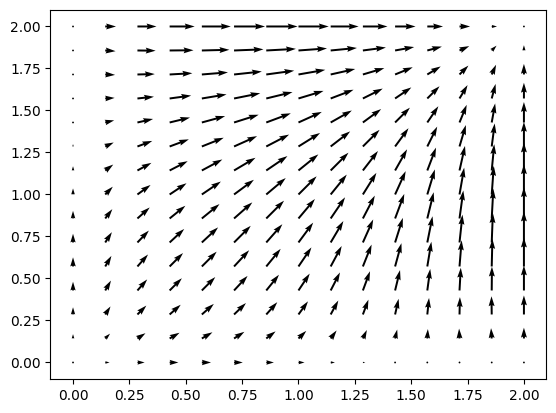

In [2]:
psicalc = PsiCalculator(n=2)
X = []
Y = []
U = []
V = []
for f1 in np.linspace(0, 2.0, 15):
    for g1 in np.linspace(0.0, 2.0, 15):
        Psi = psicalc.computeReducedAt(np.array([[f1]]), np.array([[g1]]))
        U.append(Psi["Psif"][0])
        V.append(Psi["Psig"][0])
        X.append(f1)
        Y.append(g1)
plt.quiver(X, Y, U, V)
plt.show()

# Animation of Replicator Dynamics
This is quite slow: with n=8 and n_frames=1000, takes about 2 minutes to terminate.

In [3]:
n = 8
n_frames = 100
# Computing a frame seems to take relatively long,
# so do multiple iterations before showing the next frame
iterations_per_frame = 4

h = 0.1


psicalc = PsiCalculator(n)

equilibrium = get_equilibrium(n)

f = 0.1 * np.ones((n, 1))
f[4:5, 0] = np.ones((1,))
f = f * n / f.sum()
g = 0.1 * np.ones((n, 1))
g[0:1, 0] = np.ones((1,))
g = g * n / g.sum()

fig = plt.figure()
[ax1, ax2] = fig.subplots(nrows=1, ncols=2)
dist1_text = ax1.text(
    0.05,
    5.3,
    "Dist to equilibrium: %.3f" % (np.sqrt(1.0 / n) * np.linalg.norm(f - equilibrium)),
)
line1 = ax1.stairs(
    values=f.flatten(), edges=np.linspace(start=0.0, stop=1.0, num=n + 1)
)
dist2_text = ax2.text(
    0.05,
    5.3,
    "Dist to equilibrium: %.3f" % (np.sqrt(1.0 / n) * np.linalg.norm(g - equilibrium)),
)
line2 = ax2.stairs(
    values=g.flatten(), edges=np.linspace(start=0.0, stop=1.0, num=n + 1)
)
plt.close()


def drawframe(it):
    for _ in range(iterations_per_frame):
        Psi = psicalc.computeAt(f, g)
        f[:, 0] += h * Psi["Psif"]
        g[:, 0] += h * Psi["Psig"]
    line1.set_data(
        values=f.flatten(), edges=np.linspace(start=0.0, stop=1.0, num=n + 1)
    )
    dist1_text.set_text(
        "Dist to equilibrium: %.3f"
        % (np.sqrt(1.0 / n) * np.linalg.norm(f - equilibrium))
    )
    line2.set_data(
        values=g.flatten(), edges=np.linspace(start=0.0, stop=1.0, num=n + 1)
    )
    dist2_text.set_text(
        "Dist to equilibrium: %.3f"
        % (np.sqrt(1.0 / n) * np.linalg.norm(g - equilibrium))
    )
    return (line1, line2, dist1_text, dist2_text)


anim = animation.FuncAnimation(fig, drawframe, frames=n_frames, interval=10, blit=True)
HTML(anim.to_html5_video())

# Strong Uninvadability

## Motivation

A profile $(x^*,y^*)$ is a strong uninvadable profile, if $u(x^*,y) > u(x,y)$ for all $x,y$ in a neighbourhood of $(x^*,y^*)$ for all players. (see e.g. Mendoza-Palacios 2015)

This property guarantees local stability. However, it does not hold for our game. However, we can explore, how "strong" it is violated.

## Approach
- Let $(f^*,g^*)$ be the Bayes Nash equilibrium.
- Let $\Delta$ be a random strategy and set $g = (1-\lambda)g^* + (1-\lambda)\Delta$ with $\lambda$ relatively small
- Compute the best response $f$ against $g$ in a neighbourhood of f* (this is a QCQP). More precisely, we solve $\max_{f: \lVert f - f^*\rVert_2 \leq \lVert g - g*\rVert_2} u_1(f,g)$
- Compute the utility difference $u(f^*,g)-u(f,g)$

If the game were to satisfy the strong uninvadability property, the loss would always be 0. Since this is not the case for our game, we may at least hope that the loss is small.

c:\Users\Maximilian Fichtl\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Text(0, 0.5, 'u(f*,g)-u(f,g)')

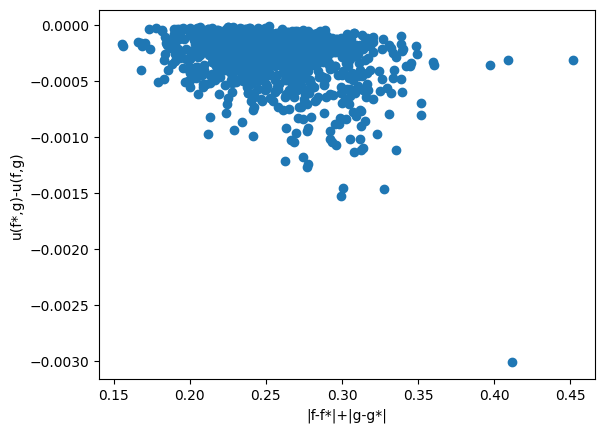

In [4]:
n = 16

utility_calculator = UtilityCalculator(n)

f_equil = get_equilibrium(n).flatten()
g_equil = get_equilibrium(n).flatten()

n_samples = 1000
utility_loss = []
rel_utility_loss = []
distances = []
for _ in range(n_samples):
    g = 0.9 * g_equil + 0.1 * random_density(n)
    dist_g = L2norm(g - g_equil)
    br = best_response_in_neighbourhood(f_equil, g, dist_g)
    distances.append(dist_g + L2norm(f_equil - br["strategy"]))
    utility_loss.append(-(br["utility"] - utility_calculator.getUtility(f_equil, g)))
    rel_utility_loss.append(
        -(br["utility"] - utility_calculator.getUtility(f_equil, g))
        / utility_calculator.getUtility(f_equil, g)
    )


plt.scatter(distances, rel_utility_loss)
plt.xlabel("|f-f*|+|g-g*|")
plt.ylabel("u(f*,g)-u(f,g)")

In the above experiment, we chose $f$ "adversarily", i.e., we choose the worst possible $f$ in a neighbourhood of $f^*$.

However, if we do not compute the best response $f$ against $f^*$, but sample both $g$ and $f$ randomly in a neighbourhood of $(f^*,g^*)$, the strong uniavoidability property seems to be satisfied.

Here we sample random densities $(f,g)$ and compute the losses
$u(f^*,g) - u(f,g)$
for $f = (1-\lambda)f^* + \lambda f$ and $g = (1-\lambda)g^* + \lambda g$
for several values lambda

Here, it turns out that when sampled randomly, the experiments only yield positive utility differences, telling us that f* is a better response to g than f.


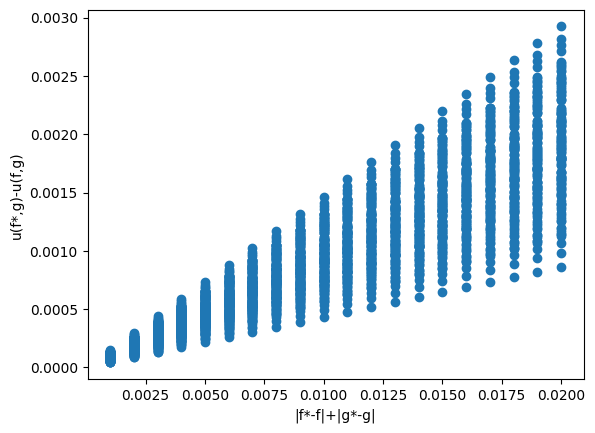

In [5]:
n = 16

utility_calculator = UtilityCalculator(n)

f_equil = get_equilibrium(n).flatten()
g_equil = get_equilibrium(n).flatten()


distance_to_equil = []
utility_diff = []

n_samples = 200
min_dist = 0.001
max_dist = 0.02
n_dists = 20


fig = plt.figure()
ax = fig.subplots(1, 1)


for _ in range(n_samples):
    f = random_density(n)
    deltaf = (f - f_equil) / L2norm(f - f_equil)
    g = random_density(n)
    deltag = (g - g_equil) / L2norm(g - g_equil)
    for a in np.linspace(min_dist, max_dist, n_dists):
        if np.min(f + a * deltaf) < 0 or np.min(g + a * deltag) < 0:
            break
        distance_to_equil.append(a)
        utility_diff.append(
            utility_calculator.getUtility(f_equil, g_equil + a * deltag)
            - utility_calculator.getUtility(f_equil + a * deltaf, g_equil + a * deltag)
        )
        # ax.plot(a, compute_utility(n,f_equil,g_equil+a*deltag) - compute_utility(n,f_equil+a*deltaf,g_equil+a*deltag))
plt.scatter(distance_to_equil, utility_diff)
plt.xlabel("|f*-f|+|g*-g|")
plt.ylabel("u(f*,g)-u(f,g)")
plt.show()

# Lyapunov Functions
Computation for n=2 is fast, for n=4 very slow. Thus, the standard beahviour is to only compute the Lyapunov function if it doesn't exist yet. If you want to force computation, set force_computation to True.

In [18]:
n = 2
max_degree = 2
force_computation = True
filename = "results/test_2.json"


if exists(filename) and not force_computation:
    raise Exception("Lyapunov function for this setting has already been computed.")

compute_lyapunov(n, filename, max_degree)



KeyboardInterrupt: 

# Plot of the Vectorfield
$$\begin{pmatrix}\nabla_f u_1(f,g)\\ \nabla_g u_2(f,g)\end{pmatrix}$$ together with the respective values of the computed Lyapunov function at each of these points (color coded). The equilibrium is at the top right corner. Of course, this works only for n=2.

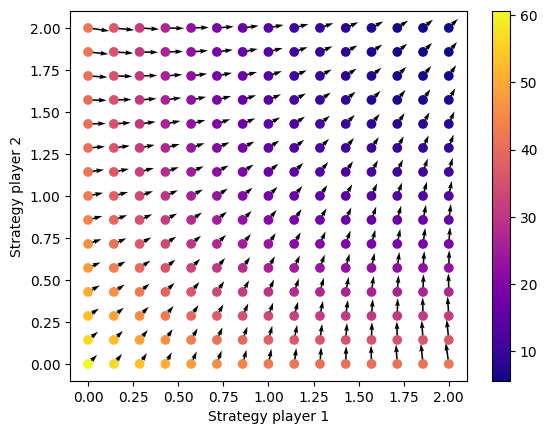

In [4]:
n = 2
assert n == 2
max_degree = 2

filename = 'results/test_2.json'

f0, g0 = sp.symbols("f0 g0")
with open(filename, 'r') as file:
    data = json.load(file)
    lyapunov_function = sp.sympify(data['solution'], locals={"f_0": f0, "g_0": g0})

f = np.array([[f0], [2 - f0]])
g = np.array([[g0], [2 - g0]])

utility_calculator = UtilityCalculator(n)

X = []
Y = []
U = []
V = []
lyapunov_values = []
for fval in np.linspace(0, 2.0, 15):
    for gval in np.linspace(0.0, 2.0, 15):
        subs = {f0: fval, g0: gval}
        U.append(utility_calculator.getReducedUtilityGradient([fval],[gval]))
        V.append(utility_calculator.getReducedUtilityGradient([gval],[fval]))
        X.append(fval)
        Y.append(gval)
        lyapunov_values.append(
            float(lyapunov_function.evalf(subs={f0: fval - 2, g0: gval - 2}))
        )
plt.quiver(X, Y, U, V)
sc = plt.scatter(X, Y, c=lyapunov_values, cmap="plasma")
plt.colorbar(sc)
plt.xlabel("Strategy player 1")
plt.ylabel("Strategy player 2")
plt.show()

Simulation of replicator dynamics. We evaluate the value of the Lyapunov function in each iteration. Ideally, the value should be monotonically decreasing. **Note however**, that we computed the Lyapunov function with respect to the projected gradient dynamics, not with respect to the replicator dynamics. Thus, if we find an example where the function is not decreasing, this doesn't necessarily mean that there is a bug in the Lyapunov computation code.  Currently, Lyapunov functions for $n \in \{2,4\}$ have been computed.

In [13]:
n = 4
h = 0.1
n_frames = 1000
iterations_per_frame = 4

filename = f'results/n={n}.json'
lyapunov_function, f_symbols, g_symbols = load_lyapunov(
    filename
)

lyapunov_computer = sp.lambdify(
    np.concatenate([f_symbols, g_symbols]).tolist(), lyapunov_function, "numpy"
)

utility_calculator = UtilityCalculator(n)
f = random_density(n)
g = random_density(n)
equilibrium = get_equilibrium(n).flatten()

edges = np.linspace(start=0.0, stop=1.0, num=n + 1)
fig = plt.figure()
fig.set_size_inches(9, 3)
[ax1, ax2, ax3] = fig.subplots(nrows=1, ncols=3)
line1 = ax1.stairs(values=f.flatten(), edges=edges)
ax1.set_ylim([0, 4])
line2 = ax2.stairs(values=g.flatten(), edges=edges)
ax2.set_ylim([0, 4])
line3 = ax3.plot([])[0]
ax3.set_ylim([0, 500])
ax3.set_xlim([0, iterations_per_frame * n_frames])
plt.close()

lyapunov_values = []


def drawframe(it):
    global f
    global g
    global edges
    for _ in range(iterations_per_frame):
        grad_f = utility_calculator.getUtilityGradient(f, g)
        grad_g = utility_calculator.getUtilityGradient(g, f)
        f = project_to_L2_simplex(f + h * grad_f)
        g = project_to_L2_simplex(g + h * grad_g)
        f_centered_reduced = (f - equilibrium)[:-1]
        g_centered_reduced = (g - equilibrium)[:-1]
        param = np.concatenate([f_centered_reduced, g_centered_reduced])
        lyapunov_values.append(lyapunov_computer(*param))
    line1.set_data(values=f.flatten(), edges=edges)
    line2.set_data(values=g.flatten(), edges=edges)
    line3.set_data(list(range(len(lyapunov_values))), lyapunov_values)
    return (line1, line2, line3)


anim = animation.FuncAnimation(fig, drawframe, frames=n_frames, interval=10, blit=True)
from IPython.display import HTML

HTML(anim.to_html5_video())

It turns out that for n=4, all monomials of the Lyapunov function with non-zero coefficients have degree 2. The following plot shows the coefficients of the respective monomials.

Poly(26.3534400463104*f_0**2 + 6.70567989349365*f_0*f_1 + 3.59959983825684*f_0*f_2 - 5.47313022613525*f_0*g_0 - 0.806280136108398*f_0*g_1 + 2.63144016265869*f_0*g_2 + 26.3534400463104*f_1**2 + 3.59959983825684*f_1*f_2 - 0.806280136108398*f_1*g_0 - 5.47313022613525*f_1*g_1 + 2.63144016265869*f_1*g_2 + 30.4399299621582*f_2**2 + 2.63144016265869*f_2*g_0 + 2.63144016265869*f_2*g_1 - 3.78486013412476*f_2*g_2 + 26.3534400463104*g_0**2 + 6.70567989349365*g_0*g_1 + 3.59959983825684*g_0*g_2 + 26.3534400463104*g_1**2 + 3.59959983825684*g_1*g_2 + 30.4399199485779*g_2**2 + 11.0616999864578, f_0, f_1, f_2, g_0, g_1, g_2, domain='RR')
(f_0, f_1, f_2, g_0, g_1, g_2)


C:\Users\Maximilian Fichtl\AppData\Local\Temp\ipykernel_11508\4006009925.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.concatenate([[""], f_symbols, g_symbols]))
C:\Users\Maximilian Fichtl\AppData\Local\Temp\ipykernel_11508\4006009925.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.concatenate([[""], f_symbols, g_symbols]))


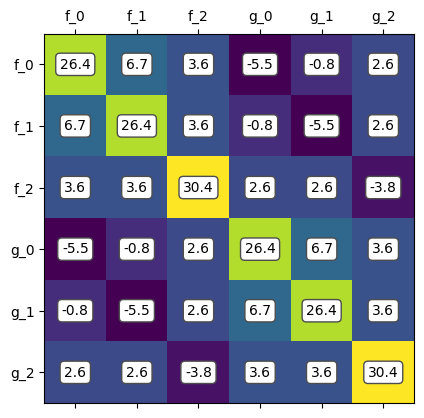

In [16]:
n = 4
file = open(f"results/lyapunov_n={n}_deg=2.txt")
f_symbols = sp.symarray("f", (n - 1,))
g_symbols = sp.symarray("g", (n - 1,))
f_locals = {str(fsym): fsym for fsym in f_symbols}
g_locals = {str(gsym): gsym for gsym in g_symbols}
lyapunov_function = sp.sympify(file.read(), locals=f_locals | g_locals)
file.close()

rounded_poly = round_poly_coefficients(sp.Poly(lyapunov_function), 5)
print(rounded_poly)
print(rounded_poly.gens)


fig, ax = plt.subplots()


coeff_matrix = np.zeros(shape=(2 * (n - 1), 2 * (n - 1)))

for exponents, coeff in rounded_poly.as_dict().items():
    exp_array = np.array(exponents)
    if np.sum(exponents) == 0:
        continue
    i = -1
    j = -1
    for k, l in enumerate(exponents):
        if l == 2:
            i = k
            j = k
            break
        elif l == 1 and i == -1:
            i = k
        elif l == 1:
            j = k
            break
    coeff_matrix[i, j] = coeff
    coeff_matrix[j, i] = coeff
    ax.text(
        j,
        i,
        "{:0.1f}".format(coeff),
        ha="center",
        va="center",
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
    )
    if i != j:
        ax.text(
            i,
            j,
            "{:0.1f}".format(coeff),
            ha="center",
            va="center",
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
        )


ax.matshow(coeff_matrix)
ax.set_xticklabels(np.concatenate([[""], f_symbols, g_symbols]))
ax.set_yticklabels(np.concatenate([[""], f_symbols, g_symbols]))
pass